# Aqui eu começo importando a base de dados


In [1]:
!curl http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip -o ucm
!unzip ucm
!rm ucm
!mkdir dataset
!mv UCmerced_LandUse/images dataset/
!rm -rf UCmerced_LandUse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  317M  100  317M    0     0  31.4M      0  0:00:10  0:00:10 --:--:-- 33.0M
Archive:  ucm
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced



# Acessando o arquivo das imagens com a lib 'os' e utilizando a o método os.Walk() para andar pela arvore de diretórios e encontrar as imagens '.tif'.

## Logo em seguida eu redimensiono, normalizo e separo as labels e as imagens em dua listas separadas



In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

dataset_path = '/content/UCMerced_LandUse/Images'

images = []
labels = []

class_mapping = {class_name: index for index, class_name in enumerate(sorted(os.listdir(dataset_path)))}

def process_directory(directory_path):
    for root, dirs, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith('.tif'):
                image_path = os.path.join(root, file_name)
                image = cv2.imread(image_path)
                if image is None:
                    continue
                image = cv2.resize(image, (224, 224))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = preprocess_input(image)
                image = image/255
                images.append(image)
                class_name = os.path.basename(os.path.dirname(image_path))
                label = class_mapping[class_name]
                labels.append(label)

process_directory(dataset_path)

images = np.array(images)
labels = np.array(labels)

print(f'Formato das imagens: {images.shape}')
print(f'Formato dos rótulos: {labels.shape}')


Formato das imagens: (2100, 224, 224, 3)
Formato dos rótulos: (2100,)



# Importando dependencias


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Separando em treino e teste (20% treino e 80% teste)

In [4]:
from sklearn.model_selection import train_test_split

image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.20, random_state=42)

# Verificando se existem GPU'S disponiveis no kernel e habilitando, caso sim
## Importante salientar aqui que devemos mudar o ambiente de execução para GPU


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("GPU configured successfully")
    except RuntimeError as e:
        print

Num GPUs Available:  1
GPU configured successfully


# Iniciando a VGG from Scratch ( optmizer = SGD(); activation = 'relu' e 'softmax')

In [6]:
modelo_zero = Sequential([
    VGG16(weights=None, include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(21, activation='softmax')
])

modelo_zero.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# Treinamento do modelo
hist_zero = modelo_zero.fit(image_train, label_train, epochs=50, validation_data=(image_test, label_test))

Epoch 1/50
53/53 [==============================] - 61s 720ms/step - loss: 3.0445 - sparse_categorical_accuracy: 0.0482 - val_loss: 3.0446 - val_sparse_categorical_accuracy: 0.0357
Epoch 2/50
53/53 [==============================] - 24s 460ms/step - loss: 3.0440 - sparse_categorical_accuracy: 0.0494 - val_loss: 3.0445 - val_sparse_categorical_accuracy: 0.0405
Epoch 3/50
53/53 [==============================] - 24s 453ms/step - loss: 3.0435 - sparse_categorical_accuracy: 0.0560 - val_loss: 3.0447 - val_sparse_categorical_accuracy: 0.0452
Epoch 4/50
53/53 [==============================] - 24s 455ms/step - loss: 3.0430 - sparse_categorical_accuracy: 0.0506 - val_loss: 3.0447 - val_sparse_categorical_accuracy: 0.0476
Epoch 5/50
53/53 [==============================] - 25s 466ms/step - loss: 3.0424 - sparse_categorical_accuracy: 0.0643 - val_loss: 3.0445 - val_sparse_categorical_accuracy: 0.0357
Epoch 6/50
53/53 [==============================] - 25s 466ms/step - loss: 3.0417 - sparse_cate

# Iniciando a VGG e descongelando apenas a camada FC ( optmizer = SGD(); activation = 'relu' e 'softmax')

In [7]:

modelo_fc = Sequential([
    VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(21, activation='softmax')
])

# Congelando as camadas convolucionais
for layer in modelo_fc.layers[0].layers[:-4]:
    layer.trainable = False

# Compilação do modelo
modelo_fc.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# Treinamento do modelo
hist_fc = modelo_fc.fit(image_train, label_train, epochs=50, validation_data=(image_test, label_test))


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
53/53 [==============================] - 12s 209ms/step - loss: 1.8702 - sparse_categorical_accuracy: 0.4476 - val_loss: 1.0668 - val_sparse_categorical_accuracy: 0.6619
Epoch 2/50
53/53 [==============================] - 11s 207ms/step - loss: 0.5002 - sparse_categorical_accuracy: 0.8411 - val_loss: 0.4780 - val_sparse_categorical_accuracy: 0.8190
Epoch 3/50
53/53 [==============================] - 11s 210ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.9554 - val_loss: 1.0396 - val_sparse_categorical_accuracy: 0.7810
Epoch 4/50
53/53 [==============================] - 11s 209ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9863 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.8952
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.2683 - val_sparse_categorical_accuracy: 0.9048
Epoch 6/50
53/53 [============

# Iniciando a VGG Transfer learning ( optmizer = SGD(); activation = 'relu' e 'softmax')

In [8]:
modelo_transfer = Sequential([
    VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(21, activation='softmax')
])

# Congelando as camadas convolucionais
for layer in modelo_transfer.layers[0].layers:
    layer.trainable = True

# Compilação do modelo
modelo_transfer.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# Treinamento do modelo
hist_transfer = modelo_transfer.fit(image_train, label_train, epochs=50, validation_data=(image_test, label_test))


Epoch 1/50
53/53 [==============================] - 27s 482ms/step - loss: 2.8660 - sparse_categorical_accuracy: 0.1685 - val_loss: 1.8403 - val_sparse_categorical_accuracy: 0.4119
Epoch 2/50
53/53 [==============================] - 25s 469ms/step - loss: 1.4894 - sparse_categorical_accuracy: 0.5655 - val_loss: 1.6316 - val_sparse_categorical_accuracy: 0.5214
Epoch 3/50
53/53 [==============================] - 24s 454ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.8179 - val_loss: 0.7622 - val_sparse_categorical_accuracy: 0.7738
Epoch 4/50
53/53 [==============================] - 25s 470ms/step - loss: 0.2114 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.9024
Epoch 5/50
53/53 [==============================] - 25s 472ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.3740 - val_sparse_categorical_accuracy: 0.8905
Epoch 6/50
53/53 [==============================] - 25s 471ms/step - loss: 0.0222 - sparse_cate

# Resumo em gráfico da variação da função de perda em detrimento da acurácia entre as épocas


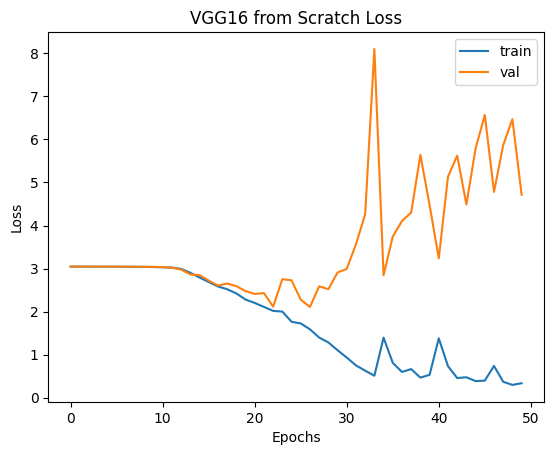

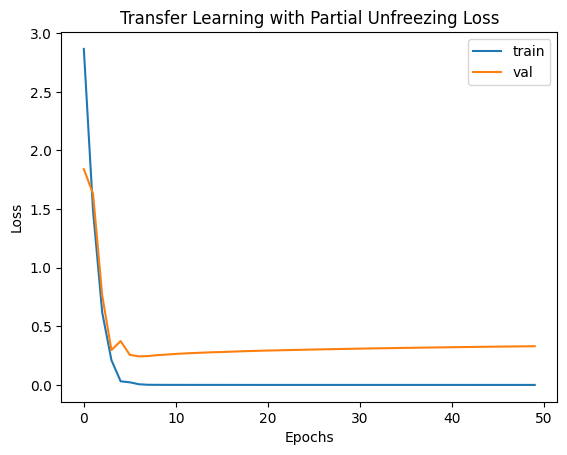

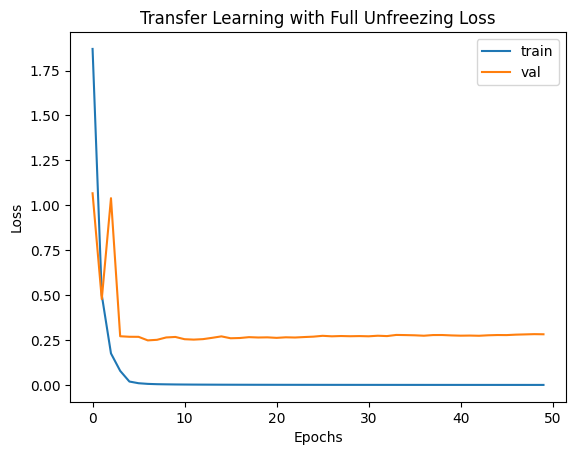

14/14 [==============================] - 2s 123ms/step - loss: 0.3302 - sparse_categorical_accuracy: 0.9357
Accuracy - Scratch: 0.34285715222358704
Accuracy - Transfer Learning (FC): 0.9047619104385376
Accuracy - Transfer Learning (Full): 0.9357143044471741


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotando as funções de perda para cada abordagem
plot_loss(hist_zero, 'VGG16 from Scratch Loss')
plot_loss(hist_transfer, 'Transfer Learning with Partial Unfreezing Loss')
plot_loss(hist_fc, 'Transfer Learning with Full Unfreezing Loss')

# Avaliando e comparando a acurácia das três abordagens
loss_scratch, accuracy_scratch = modelo_zero.evaluate(image_test, label_test)
loss_transfer_fc, accuracy_transfer_fc = modelo_fc.evaluate(image_test, label_test)
loss_transfer_full, accuracy_transfer_full = modelo_transfer.evaluate(image_test, label_test)

print('Accuracy - Scratch:', accuracy_scratch)
print('Accuracy - Transfer Learning (FC):', accuracy_transfer_fc)
print('Accuracy - Transfer Learning (Full):', accuracy_transfer_full)

# Salvando os modelos
modelo_zero.save('vgg16_zero_model.h5')
modelo_fc.save('vgg16_fc_model.h5')
modelo_transfer.save('vgg16_transfer_model.h5')




# Comparativo da acurácia final entre os modelos



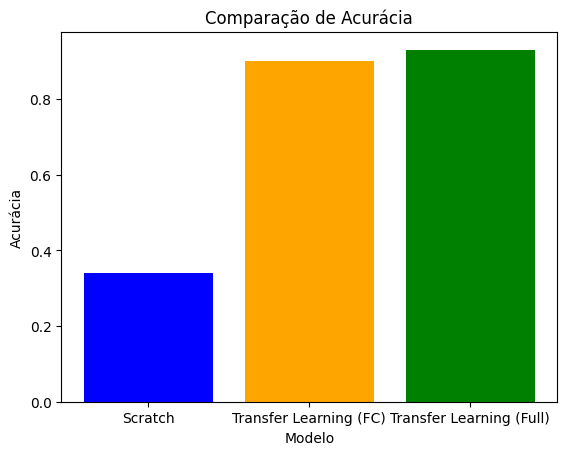

In [16]:
import matplotlib.pyplot as plt

acuracia = [0.34, 0.90, 0.93]
labels = ['Scratch', 'Transfer Learning (FC)', 'Transfer Learning (Full)']


plt.bar(labels, acuracia, color=['blue', 'orange', 'green'])

plt.title('Comparação de Acurácia')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')

plt.show()
